In [1]:
# 모듈 불러오기
import pandas as pd
import os
import warnings
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()
warnings.filterwarnings("ignore")

In [2]:
# 리포트 데이터 불러오기
report_data = pd.read_csv("../../QUANT_DATA/201609~202108/기업리포트/기업리포트_요약.csv", encoding = "cp949")
report_data.head()

작성일       종목명    종목코드  \
0  2021-08-31      애경유화  161000   
1  2021-08-31      명신산업    9900   
2  2021-08-31  갤럭시아머니트리   94480   
3  2021-08-31     LX세미콘  108320   
4  2021-08-31    에스에프에이   56190   

                                                  제목     적정가격      평가의견  작성자  \
0    화학 3 사 통합에 따 화학 3 사 통합에 따른 변화 화학 3 사 통합에 따른 변화         0  NotRated  전우제   
1   NDR 후기 남은 방지 NDR 후기 남은 방지턱은 단 하나 NDR 후기 남은 방지...        0  NotRated  박준호   
2                신사업을 통 신사업을 통한 도약 기대 신사업을 통한 도약 기대         0        nr  김용호   
3             시장 우려에 대한 반 시장 우려에 대한 반론 시장 우려에 대한 반론   230,000       Buy  정원석   
4   소를 잃었으면 소를 잃었으면 외양간을 고치는 게 국룰 소를 잃었으면 외양간을 고치...   70,000       Buy  이승철   

      작성기관  
0   한화투자증권  
1   한화투자증권  
2     한양증권  
3   하이투자증권  
4  카카오페이증권

In [38]:
# 리포트가 자주 등장하는 상위 20개 종목 확인
report_data['종목명'].value_counts(normalize = True).head(20)

삼성전자       0.018073
SK하이닉스     0.012007
LG전자       0.011918
엔씨소프트      0.011545
삼성전기       0.011171
NAVER      0.010904
현대차        0.010673
LG이노텍      0.010282
LG디스플레이    0.010175
SK텔레콤      0.010104
LG화학       0.009641
기아         0.009250
롯데케미칼      0.008912
카카오        0.008894
POSCO      0.008699
삼성SDI      0.008681
LG유플러스     0.008556
SK이노베이션    0.008556
현대모비스      0.008485
KT         0.008325
Name: 종목명, dtype: float64

#### 간단한 탐색 및 전처리

In [5]:
# 적정 가격 숫자로 변환하기
report_data['적정가격'] = report_data['적정가격'].str.replace(",", "").astype(int)

In [6]:
# 적정 가격 분포 --- 0으로 되어 있는 것이 존재 --> 삭제
report_data['적정가격'].describe()

count    7.848600e+04
mean     1.465265e+05
std      3.057968e+05
min      0.000000e+00
25%      1.600000e+04
50%      5.350000e+04
75%      1.550000e+05
max      1.100000e+07
Name: 적정가격, dtype: float64

In [7]:
# 적정 가격이 0이 아닌 것으로 필터링 수행
report_data = report_data.loc[report_data['적정가격'] > 0]

In [8]:
# 평가의견 통일하기
report_data['평가의견'].unique()

array(['Buy', 'Hold', '중립', 'marketperform', '매수', 'neutral',
       'Outperform', 'nr', 'TradingBuy', 'StrongBuy', '-', 'underperform',
       'NotRated', 'Reduce', '적극매수', 'Sell', '보유', 'Neutral'],
      dtype=object)

In [9]:
# 의견 분리 -- buy / neutral / sell
# 확실한 주장이 없는 의견 무시
temp = {"Buy":"buy", "TradingBuy":"buy", "매수":"buy", "StrongBuy":"buy", "적극매수":"buy",
       "중립":"neutral", "보유":"neutral", "중립":"neutral", "보유":"neutral", "Neutral":"neutral", "Hold":"neutral",
       "Reduce":"sell", "축소":"sell"}

report_data['평가의견'] = report_data['평가의견'].replace(temp)

In [10]:
# buy가 압도적으로 많고, 그 다음 neutral --> 이 둘만 고려하기
# sell은 역시 거의 없음
report_data['평가의견'].value_counts()

buy              61585
neutral           3808
marketperform      877
Outperform         249
-                  110
underperform        27
sell                18
nr                   6
NotRated             3
적극매수                 3
Sell                 1
Name: 평가의견, dtype: int64

In [11]:
report_data = report_data.loc[report_data['평가의견'].isin(["buy", "neutral"])]

In [12]:
# 작성일 날짜로 바꾸기
report_data['작성일'] = pd.to_datetime(report_data['작성일'])

In [13]:
# 최대 1년 후까지 예측해야 하므로 작성일이 2020년 9월 1일 이전인 것만 필터링
# 현재 보유 중인 데이터 기간이 2016년 9월 1일 ~ 2021년 8월 31일까지임
report_data = report_data.loc[report_data['작성일'] < pd.to_datetime("2020/09/01")]

In [14]:
# 자주 등장하는 종목 주가 데이터 붙이기
# 리포트에 등장한 종목 목록 정의
stock_name_list = report_data['종목명'].unique()

stock_price_data = dict() # key: 종목 이름, value: 종목의 주가 데이터 (2016-09-01 ~ 2021-09-30)
for stock_name in stock_name_list:
    # 코스피 폴더에 있으면 코스피 폴더에서 데이터를 가져와서 stock_price_data에 추가
    if stock_name + ".csv" in os.listdir("../../QUANT_DATA/201609~202108/주가/일/KOSPI"):
        data = pd.read_csv("../../QUANT_DATA/201609~202108/주가/일/KOSPI/" + stock_name + ".csv", encoding = "cp949")
        # 날짜를 datetime 형태로 변환
        YYYY = data["날짜"].astype(str).str[:4]
        MM = data["날짜"].astype(str).str[4:6]
        DD = data["날짜"].astype(str).str[6:8]
        data["날짜"] = pd.to_datetime(YYYY + "/" + MM + "/" + DD)
        
        data.set_index("날짜", inplace = True) # 날짜를 인덱스로 설정
        stock_price_data[stock_name] = data
        
        
    # 코스닥 폴더에 있으면 코스닥 폴더에서 데이터를 가져와서 stock_price_data에 추가
    elif stock_name + ".csv" in os.listdir("../../QUANT_DATA/201609~202108/주가/일/KOSDAQ"):
        data = pd.read_csv("../../QUANT_DATA/201609~202108/주가/일/KOSDAQ/" + stock_name + ".csv", encoding = "cp949")
        YYYY = data["날짜"].astype(str).astype(str).str[:4]
        MM = data["날짜"].astype(str).astype(str).str[4:6]
        DD = data["날짜"].astype(str).astype(str).str[6:8]
        data["날짜"] = pd.to_datetime(YYYY + "/" + MM + "/" + DD)

        data.set_index("날짜", inplace = True) # 날짜를 인덱스로 설정        
        stock_price_data[stock_name] = data
        
    # 어디에도 없으면 레포트에서 해당 종목 삭제
    else:
        report_data = report_data.loc[report_data["종목명"] != stock_name]

### 의견에 따라 종목을 구매한 뒤의 이익 계산

In [15]:
def get_nearest_close_price(data, date):
    # data에서 날짜가 date일 때의 종가 가져오기
    # 단, date일 때 장이 열리지 않았다면, 가장 최근에 열린 장의 데이터를 사용
    # 예: 2021년 10월 2일 가격이 없으면 10월 1일 가격을 가져옴
    while True:
        if date in data.index:
            return data.loc[date, '종가']
            break
        else:
            date = date - pd.to_timedelta(1, unit = "D")

#### 평가의견이 buy인 종목을 구매한 뒤, 1개월, 3개월, 6개월, 1년 후의 가격과 비교

In [16]:
result = []
for _, record in report_data.iterrows(): # 모든 행을 돌면서 
    if record["평가의견"] == "buy":
        stock_name = record['종목명']
        data = stock_price_data[stock_name]
        date = record['작성일']
        
        # 날짜 범위에 데이터가 없으면 무시
        if date < data.index.min() or date + pd.to_timedelta(365, "D") > data.index.max():
            continue
        
        # 날짜에 맞는 데이터 가져오기
        # to_timedelta에서 1M, 1Y 등이 모호하기때문에 더 이상 지원을 안함
        # 따라서 한달을 30일로 간주하여 day를 계산함
        current_price = get_nearest_close_price(data, date)
        price_after_1M = get_nearest_close_price(data, date + pd.to_timedelta(30, "D"))
        price_after_3M = get_nearest_close_price(data, date + pd.to_timedelta(90, "D"))
        price_after_6M = get_nearest_close_price(data, date + pd.to_timedelta(180, "D"))
        price_after_1Y = get_nearest_close_price(data, date + pd.to_timedelta(365, "D"))

        # 결과를 result에 추가
        result.append([stock_name, date, current_price, price_after_1M, price_after_3M, price_after_6M, price_after_1Y])

# 결과를 데이터프레임으로 변환
result = pd.DataFrame(result, columns = ["종목명", "날짜", "현재가", "1개월후가격", "3개월후가격", "6개월후가격", "1년후가격"])

In [17]:
# 결과 시각화: 한 장에 증가폭을 그려보기
temp = result[['현재가', "1개월후가격", "3개월후가격", "6개월후가격", "1년후가격"]].copy()

# 상승폭 계산
temp["1개월후상승폭"] = (temp["1개월후가격"] - temp["현재가"]) / temp["현재가"]
temp["3개월후상승폭"] = (temp["3개월후가격"] - temp["현재가"]) / temp["현재가"]
temp["6개월후상승폭"] = (temp["6개월후가격"] - temp["현재가"]) / temp["현재가"]
temp["1년후상승폭"] = (temp["1년후가격"] - temp["현재가"]) / temp["현재가"]

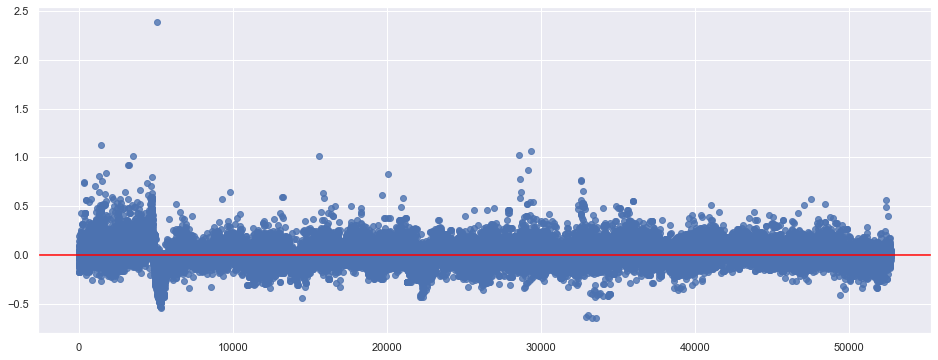

In [18]:
# 포인트가 너무 많아서 해석이 어렵지만, 육안으로 봤을 때 절반가량은 오른 것 같음 (기준선 위)
fig = plt.figure(figsize = (16, 6))
plt.scatter(range(len(temp)), temp['1개월후상승폭'], alpha = 0.8)
plt.axhline(y = 0, color = "red")

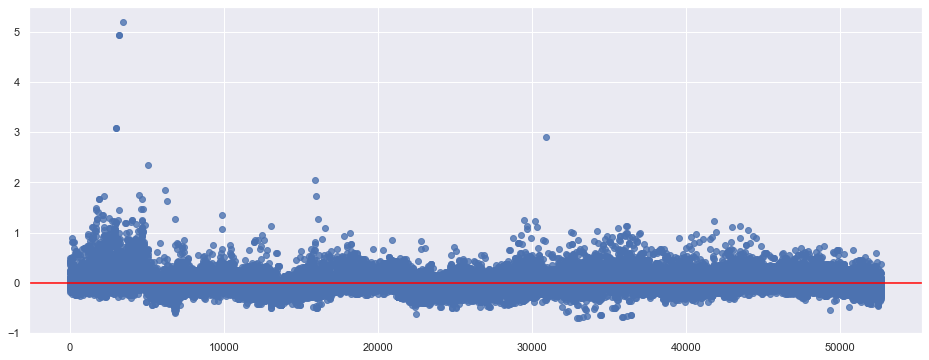

In [19]:
# 포인트가 너무 많아서 해석이 어렵지만, 기준선 위가 더 많은 것으로 보임
fig = plt.figure(figsize = (16, 6))
plt.scatter(range(len(temp)), temp['3개월후상승폭'], alpha = 0.8)
plt.axhline(y = 0, color = "red")

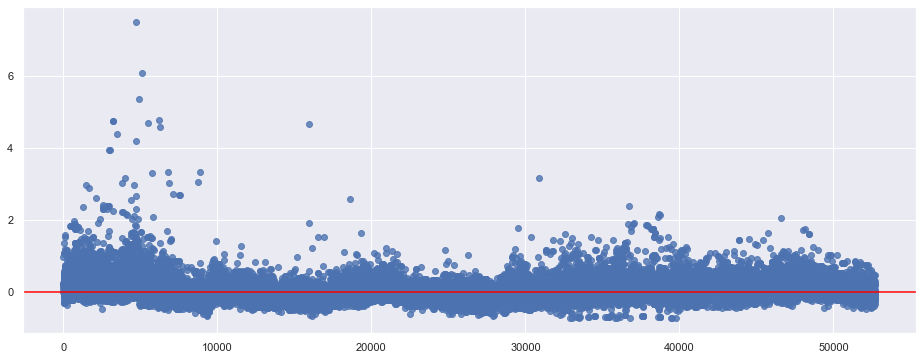

In [20]:
# 포인트가 너무 많아서 해석이 어렵지만, 육안으로 봤을 때 3개월 기다린 것보다 더 많이 오른 것으로 보임
fig = plt.figure(figsize = (16, 6))
plt.scatter(range(len(temp)), temp['6개월후상승폭'], alpha = 0.8)
plt.axhline(y = 0, color = "red")

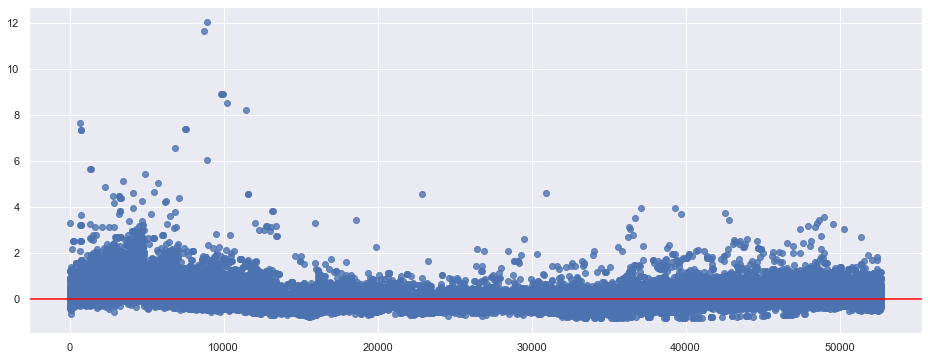

In [21]:
# 포인트가 너무 많아서 해석이 어렵지만, 1년을 버텨도 손실이 나긴하지만, 많이 수익을 봄
fig = plt.figure(figsize = (16, 6))
plt.scatter(range(len(temp)), temp['1년후상승폭'], alpha = 0.8)
plt.axhline(y = 0, color = "red")

In [22]:
# 기술적인 분석 수행
temp[["1개월후상승폭", "3개월후상승폭", "6개월후상승폭", "1년후상승폭"]].describe()

# 모두 평균적으로는 이익을 봄
# 그러나 절반 이상이 결국 손해로 이어짐 (중위수가 모두 음수)
# 최악의 경우 84%나 떨어짐...

1개월후상승폭       3개월후상승폭       6개월후상승폭        1년후상승폭
count  52705.000000  52705.000000  52705.000000  52705.000000
mean       0.003487      0.013038      0.029122      0.066851
std        0.105242      0.187102      0.283976      0.469646
min       -0.652752     -0.710422     -0.737160     -0.840800
25%       -0.058030     -0.100978     -0.139330     -0.209270
50%       -0.003591     -0.006615     -0.012069     -0.032742
75%        0.058824      0.103175      0.144737      0.217412
max        2.389015      5.199863      7.497778     12.023584

#### 평가의견이 neutral인 종목을 구매한 뒤, 1개월, 3개월, 6개월, 1년 후의 가격과 비교

In [23]:
result = []
for _, record in report_data.iterrows(): # 모든 행을 돌면서 
    if record["평가의견"] == "neutral":
        stock_name = record['종목명']
        data = stock_price_data[stock_name]
        date = record['작성일']
        
        # 날짜 범위에 데이터가 없으면 무시
        if date < data.index.min() or date + pd.to_timedelta(365, "D") > data.index.max():
            continue
        
        # 날짜에 맞는 데이터 가져오기
        # to_timedelta에서 1M, 1Y 등이 모호하기때문에 더 이상 지원을 안함
        # 따라서 한달을 30일로 간주하여 day를 계산함
        current_price = get_nearest_close_price(data, date)
        price_after_1M = get_nearest_close_price(data, date + pd.to_timedelta(30, "D"))
        price_after_3M = get_nearest_close_price(data, date + pd.to_timedelta(90, "D"))
        price_after_6M = get_nearest_close_price(data, date + pd.to_timedelta(180, "D"))
        price_after_1Y = get_nearest_close_price(data, date + pd.to_timedelta(365, "D"))

        # 결과를 result에 추가
        result.append([stock_name, date, current_price, price_after_1M, price_after_3M, price_after_6M, price_after_1Y])

# 결과를 데이터프레임으로 변환
result = pd.DataFrame(result, columns = ["종목명", "날짜", "현재가", "1개월후가격", "3개월후가격", "6개월후가격", "1년후가격"])

In [24]:
# 결과 시각화: 한 장에 증가폭을 그려보기
temp = result[['현재가', "1개월후가격", "3개월후가격", "6개월후가격", "1년후가격"]].copy()

# 상승폭 계산
temp["1개월후상승폭"] = (temp["1개월후가격"] - temp["현재가"]) / temp["현재가"]
temp["3개월후상승폭"] = (temp["3개월후가격"] - temp["현재가"]) / temp["현재가"]
temp["6개월후상승폭"] = (temp["6개월후가격"] - temp["현재가"]) / temp["현재가"]
temp["1년후상승폭"] = (temp["1년후가격"] - temp["현재가"]) / temp["현재가"]

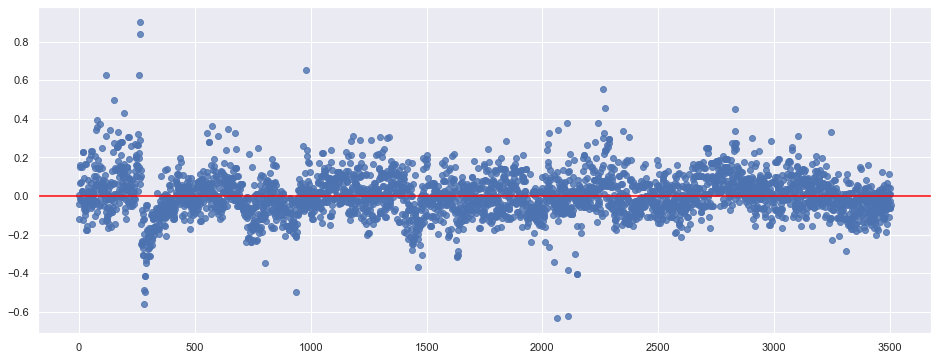

In [25]:
# 포인트가 너무 많아서 해석이 어렵지만, 육안으로 봤을 때 절반가량은 오른 것 같음 (기준선 위)
fig = plt.figure(figsize = (16, 6))
plt.scatter(range(len(temp)), temp['1개월후상승폭'], alpha = 0.8)
plt.axhline(y = 0, color = "red")

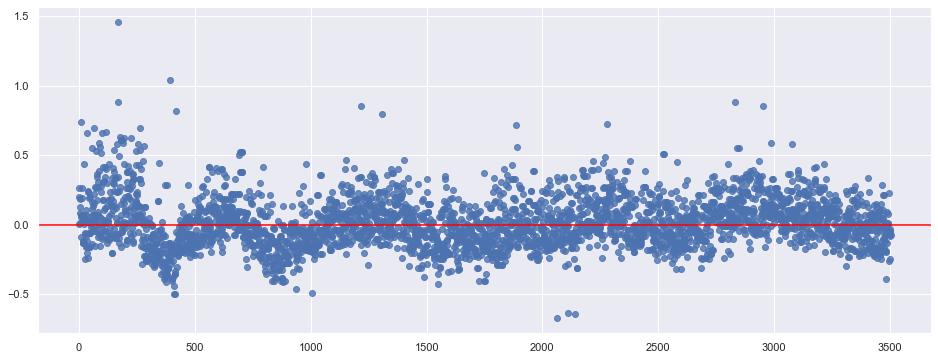

In [26]:
# 포인트가 너무 많아서 해석이 어렵지만, 기준선 위가 더 많은 것으로 보임
fig = plt.figure(figsize = (16, 6))
plt.scatter(range(len(temp)), temp['3개월후상승폭'], alpha = 0.8)
plt.axhline(y = 0, color = "red")

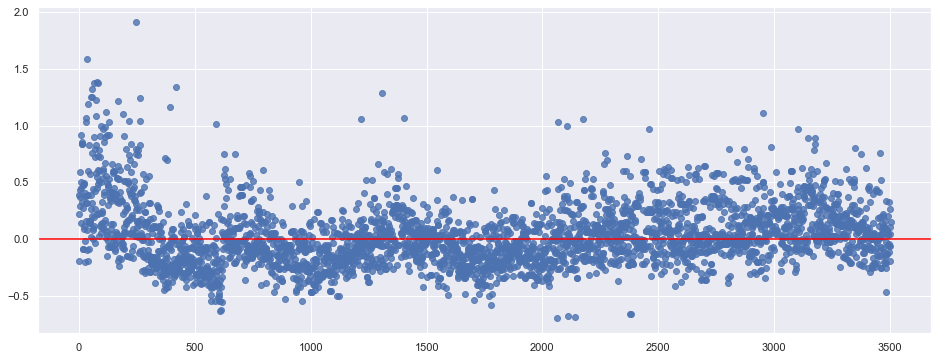

In [27]:
# 포인트가 너무 많아서 해석이 어렵지만, 육안으로 봤을 때 3개월 기다린 것보다 더 많이 오른 것으로 보임
fig = plt.figure(figsize = (16, 6))
plt.scatter(range(len(temp)), temp['6개월후상승폭'], alpha = 0.8)
plt.axhline(y = 0, color = "red")

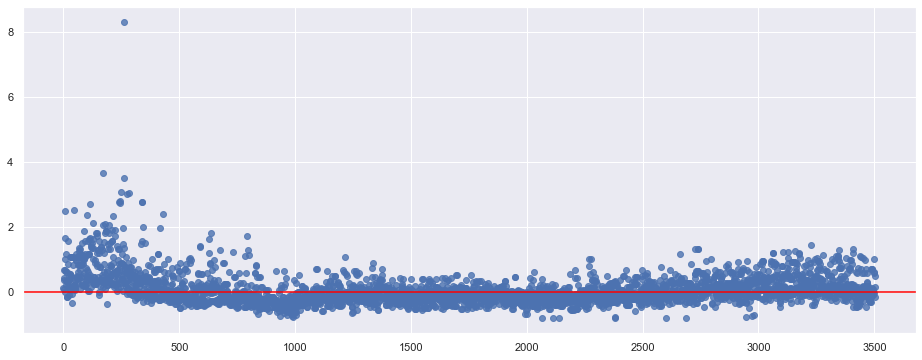

In [28]:
# 포인트가 너무 많아서 해석이 어렵지만, 1년을 버텨도 손실이 나긴하지만, 많이 수익을 봄
fig = plt.figure(figsize = (16, 6))
plt.scatter(range(len(temp)), temp['1년후상승폭'], alpha = 0.8)
plt.axhline(y = 0, color = "red")

In [29]:
# 기술적인 분석 수행
temp[["1개월후상승폭", "3개월후상승폭", "6개월후상승폭", "1년후상승폭"]].describe()

# 모두 평균적으로는 이익을 봄
# 그러나 절반 이상이 결국 손해로 이어짐 (중위수가 모두 음수)
# 최악의 경우 84%나 떨어짐...

1개월후상승폭      3개월후상승폭      6개월후상승폭       1년후상승폭
count  3504.000000  3504.000000  3504.000000  3504.000000
mean      0.003030     0.014030     0.030766     0.069014
std       0.110722     0.180114     0.275047     0.475613
min      -0.634347    -0.674839    -0.700606    -0.818932
25%      -0.060807    -0.109422    -0.153578    -0.220149
50%      -0.002507    -0.003360    -0.008186    -0.032898
75%       0.063211     0.115330     0.156925     0.221571
max       0.902098     1.460077     1.913084     8.318182

### 목표가 도달까지 걸리는 시간 및 비율 확인

In [30]:
result = pd.DataFrame()
for _, record in report_data.iterrows(): # 모든 행을 돌면서 평가의견이 buy라면
    if record["평가의견"] == "buy":
        stock_name = record['종목명']
        data = stock_price_data[stock_name]
        date = record['작성일']
        fair_price = record["적정가격"]
        time_to_fair_price = -1
        
        # 날짜 범위에 데이터가 없으면 무시
        if date < data.index.min() or date + pd.to_timedelta(365, "D") > data.index.max():
            continue
        
        if sum((data['종가'] >= fair_price) & (data.index > date)): # 적정가격까지 도달한 기록이 있다면
            date_fair_price = data.loc[(data['종가'] >= fair_price) & (data.index > date)].iloc[-1].name
            time_to_fair_price = (date_fair_price - date).days
        
        # 소요기간 추가
        record.loc["소요기간"] = time_to_fair_price
        result = result.append(record)

In [31]:
# 최소 1년 내 적정 가격에 도달하지 못한 비율
sum(result['소요기간'] == -1) / len(result)

0.43521487524902763

In [32]:
# 적정 가격까지 도달하는데 소요되는 시간에 대한 분포
# 최소값이 1인 것은 이상.... 하루만에 적정 가격 도달?
result.loc[result['소요기간'] > -1, '소요기간'].describe()

count    29767.000000
mean       434.239359
std        395.581444
min          1.000000
25%        119.000000
50%        294.000000
75%        669.000000
max       1816.000000
Name: 소요기간, dtype: float64

In [33]:
# 이틀만에 도달하는 것도 이상함 --> 적정 주가라는 것이 현재 주가랑 크게 관련이 없음 (현재 주가가 적정 주가인 경우도..)
result.loc[result['소요기간'] == 2]

소요기간     작성기관        작성일      작성자      적정가격  \
11413   2.0   유진투자증권 2020-08-24      박종선   47000.0   
12181   2.0     교보증권 2020-08-03      김정현  650000.0   
12222   2.0    유안타증권 2020-08-03  서미화,이혜인   64000.0   
12241   2.0   하나금융투자 2020-08-03      선민정  180000.0   
12247   2.0   하나금융투자 2020-08-03      선민정  260000.0   
12659   2.0     SK증권 2020-07-22      이달미  250000.0   
12828   2.0     대신증권 2020-07-15      박강호   12000.0   
13258   2.0   하나금융투자 2020-07-06  이정기,안주원   16650.0   
14802   2.0     삼성증권 2020-05-18      장효선   85000.0   
16247   2.0     삼성증권 2020-04-21      서근희  600000.0   
18541   2.0     대신증권 2020-02-11      한상원  410000.0   
23821   2.0  메리츠종금증권 2019-09-02      정지수   40000.0   
26381   2.0     대신증권 2019-07-09  한경래,이새롬   45000.0   
27573   2.0   하나금융투자 2019-06-05      이기훈    6600.0   
28721   2.0     키움증권 2019-05-15      서혜원   28000.0   
33337   2.0     삼성증권 2019-02-12      조상훈   33000.0   
40414   2.0   미래에셋대우 2018-10-08      박정엽    8400.0   
40609   2.0    유안타증권 2018-10-02      박성호   11000.0   
40641   2.0     삼성증권 2018-10-02  양승우,최준성    8200.0   
45636   2.0     키움증권 2018-06-12      이창희    6000.0   
45652   2.0     대신증권 2018-06-12      김회재    9000.0   
47693   2.0   하나금융투자 2018-05-08  김홍식,성도훈   12850.0   
48040   2.0   신한금융투자 2018-04-30      오경석   60000.0   
48063   2.0   유진투자증권 2018-04-30      이상우   61000.0   
48142   2.0     KB증권 2018-04-30  장문준,정동익   58500.0   
48181   2.0  KTB투자증권 2018-04-30      김선미   61000.0   
48200   2.0   한국투자증권 2018-04-30  이경자,김치호   61000.0   
52520   2.0     삼성증권 2018-01-24      윤선영   37000.0   
53456   2.0     SK증권 2018-01-08      손지우  180000.0   
54695   2.0  메리츠종금증권 2017-11-27       김현   11000.0   
57970   2.0   NH투자증권 2017-10-11      구완성  120000.0   
57997   2.0     KB증권 2017-10-11  서근희,이지수  123000.0   
58970   2.0     삼성증권 2017-08-29      임은영   37000.0   
59525   2.0   유진투자증권 2017-08-14      장호윤  135000.0   
62966   2.0   이베스트증권 2017-06-07      어규진  155000.0   
63008   2.0   한화투자증권 2017-06-07  이상원,이제연  280000.0   
64468   2.0   이베스트증권 2017-05-15      성종화   55000.0   
65002   2.0   하나대투증권 2017-05-08      심은주  250000.0   
65053   2.0   미래에셋대우 2017-05-02      김태희   95000.0   
68537   2.0   신한금융투자 2017-02-28  홍세종,오경석    5600.0   
68543   2.0     대신증권 2017-02-28      김회재    6500.0   
74779   2.0  메리츠종금증권 2016-11-08      양지혜  180000.0   

                                                      제목       종목명      종목코드  \
11413   Conference Call Conference Call 2Q20 실적 Revie...     서진시스템  178320.0   
12181   2Q Re 차화정을 넘어 2Q Re 차화정을 넘어선 새로운 시작 2Q Re 차화정...      LG화학   51910.0   
12222   2Q20 Review 반가운 2Q20 Review 반가운 어닝서프라이즈 매출액4 ...      유한양행     100.0   
12241   사상 최대 실적 사상 최대 실적 시현 2분기 양호한 실적 예상은 했지만 이 정도일...       종근당  185750.0   
12247   2분기에 대한 실망보다 2분기에 대한 실망보다 3분기 기대할 것이 더 많다 2분기...       녹십자    6280.0   
12659   아스트라제네카 수주 아스트라제네카 수주계약 체결로 주가 리레이팅 전망 아스트라제네...     SK케미칼  285130.0   
12828   비메모리 투자 본격 비메모리 투자 본격화 도약 기대 비메모리반도체 용 FC BGA...      대덕전자  353200.0   
13258   120억원의 현금 출 120억원의 현금 출자는 하반기 실적 상승의 반증 투자의견 ...     에이스테크   88800.0   
14802   1Q review 2 Q V 자 1Q review 2 Q V 자 반등 기대 1Q ...      키움증권   39490.0   
16247   코로나 19 코로나 19 로 인한 CMO 시장 재편에 따른 수혜 발표실적 vs 컨...  삼성바이오로직스  207940.0   
18541                                    사필귀정 사필귀정 사필귀정       LG화학   51910.0   
23821                의 5G 는 지금부 의 5G 는 지금부터 의 5G 는 지금부터      RFHIC  218410.0   
26381   한국을 넘어 글 한국을 넘어 글로벌로 Feat 중국 한국을 넘어 글로벌로 Feat...    케이엠더블유   32500.0   
27573    보좌관부터 연말 보좌관부터 연말까지 라인업이 좋다 보좌관부터 연말까지 라인업이 좋다     제이콘텐트리   36420.0   
28721   플랫폼 기업의 정석 플랫폼 기업의 정석 1Q19 연결기준 매출액 267억원 23 ...       다나와  119860.0   
33337    2019년 경쟁력이 2019년 경쟁력이 부각될 시기 2019년 경쟁력이 부각될 시기    CJ프레시웨이   51500.0   
40414           19년 투자 본격 19년 투자 본격화를 기대 19년 투자 본격화를 기대     제이콘텐트리   36420.0   
40609         중국향 드라마 중국향 드라마 구작 판매 재개 중국향 드라마 구작 판매 재개     제이콘텐트리   36420.0   
40641     국내 Top 2 드라 국내 Top 2 드라마 제작사 국내 Top 2 드라마 제작사     제이콘텐트리   36420.0   
45636                   재무구조 개선 재무구조 개선 가시화 재무구조 개선 가시화     아시아나항공   20560.0   
4565

In [34]:
# 현 주가와 적정 가격의 차이가 10% 이상 나는데도 잘 맞춘 케이스만 필터링
result = pd.DataFrame()
for _, record in report_data.iterrows(): # 모든 행을 돌면서 평가의견이 buy라면
    if record["평가의견"] == "buy":
        stock_name = record['종목명']
        data = stock_price_data[stock_name]
        date = record['작성일']
        fair_price = record["적정가격"]
        
        time_to_fair_price = -1
        
        # 날짜 범위에 데이터가 없으면 무시
        if date < data.index.min() or date + pd.to_timedelta(365, "D") > data.index.max():
            continue
        
        current_price = get_nearest_close_price(data, date)
        if abs(fair_price - current_price) / current_price < 0.1:
            continue
        
        if sum((data['종가'] >= fair_price) & (data.index > date)): # 적정가격까지 도달한 기록이 있다면
            date_fair_price = data.loc[(data['종가'] >= fair_price) & (data.index > date)].iloc[-1].name
            time_to_fair_price = (date_fair_price - date).days
        
        # 소요기간 추가
        record.loc["소요기간"] = time_to_fair_price
        result = result.append(record)

In [40]:
result.loc[result['소요기간'] > 0, '소요기간'].describe()

count    28817.000000
mean       444.004824
std        395.574743
min          1.000000
25%        128.000000
50%        306.000000
75%        685.000000
max       1816.000000
Name: 소요기간, dtype: float64

In [36]:
count_result = pd.Series()
for idx in result['작성기관'].value_counts().index:
    count_result[idx] = result.loc[result['소요기간'] > 0, '작성기관'].value_counts().loc[idx] / sum(report_data['작성기관'] == idx)

In [37]:
count_result.sort_values(ascending = False)

메리츠증권      1.000000
NH농협증권     1.000000
대신증권       0.586133
현대차투자증권    0.574026
교보증권       0.573306
HMC투자증권    0.566004
키움증권       0.565271
유진투자증권     0.561234
이베스트증권     0.556110
IBK투자증권    0.536937
미래에셋대우     0.532917
한양증권       0.531100
하이투자증권     0.528354
신한금융투자     0.527973
미래에셋증권     0.513699
메리츠종금증권    0.504451
삼성증권       0.503872
하나금융투자     0.501110
SK증권       0.485356
현대증권       0.484694
하나대투증권     0.475915
한화투자증권     0.474743
KTB투자증권    0.470322
유안타증권      0.463384
NH투자증권     0.446197
한국투자증권     0.444444
KB증권       0.412558
dtype: float64